# Classification Analysis of Patient Parameters on Stroke Predictions

In [1]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
install.packages("generics")
install.packages("themis")
require(themis)


options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0     ✔ recipes   0.2.0
✔ dials     0.0.9     ✔ rsample   0.0.7
✔ infer     0.5.4     ✔ tune      0.1.1
✔ modeldata 0.0.2     ✔ workflows 0.2.0
✔ parsnip   0.1.3     ✔ yards

## Introduction

## Methods and Results

In [11]:
set.seed(1768)
raw_data_url <- "https://raw.githubusercontent.com/jordanjzhao/dsci-project-proposal/main/data/healthcare-dataset-stroke-data.csv"
stroke_data <- read.csv(raw_data_url, na.strings = "N/A") %>%
    mutate(stroke = as_factor(stroke))

stroke_data_clean <- na.omit(stroke_data)
head(stroke_data_clean)

# Select data
stroke_data_select <- stroke_data_clean %>%
    select(stroke, bmi, avg_glucose_level)
stroke_data_select

# Create training and testing set
stroke_split <- initial_split(stroke_data_select, prop = 0.75, strata = stroke)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split)
glimpse(stroke_test)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>
1,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
3,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
4,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
5,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
6,56669,Male,81,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
7,53882,Male,74,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1


,stroke,bmi,avg_glucose_level
,<fct>,<dbl>,<dbl>
1,1,36.6,228.69
3,1,32.5,105.92
4,1,34.4,171.23
⋮,⋮,⋮,⋮
5108,0,30.6,82.99
5109,0,25.6,166.29
5110,0,26.2,85.28


Rows: 1,227
Columns: 3
$ stroke            <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ bmi               <dbl> 27.4, 28.2, 22.4, 22.2, 26.5, 23.1, 32.0, 33.6, 22.…
$ avg_glucose_level <dbl> 70.09, 214.09, 193.94, 196.92, 84.03, 74.63, 92.62,…


bmi,avg_glucose_level,stroke
<dbl>,<dbl>,<fct>
-1.4107190,-0.2295377,0
-1.4625420,0.1246413,0
0.9083643,-0.8152694,0
⋮,⋮,⋮
0.3642219,3.4651985,1
1.6338876,-0.9246449,1
-0.6074611,-0.8267235,1


`summarise()` ungrouping output (override with `.groups` argument)



stroke,n
<fct>,<int>
0,3524
1,3524


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.9236833,5,0.002514704,Model1
2,roc_auc,binary,0.5132673,5,0.011598812,Model1
4,accuracy,binary,0.9519309,5,0.003775361,Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,roc_auc,binary,0.5858588,5,0.026080104,Model8
14,accuracy,binary,0.9570921,5,0.005228758,Model9
14,roc_auc,binary,0.5999176,5,0.023984888,Model9


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.9236833,5,0.002514704,Model1
4,accuracy,binary,0.9519309,5,0.003775361,Model2
6,accuracy,binary,0.9546476,5,0.004529093,Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,binary,0.9570921,5,0.005228758,Model7
13,accuracy,binary,0.9570921,5,0.005228758,Model8
14,accuracy,binary,0.9570921,5,0.005228758,Model9


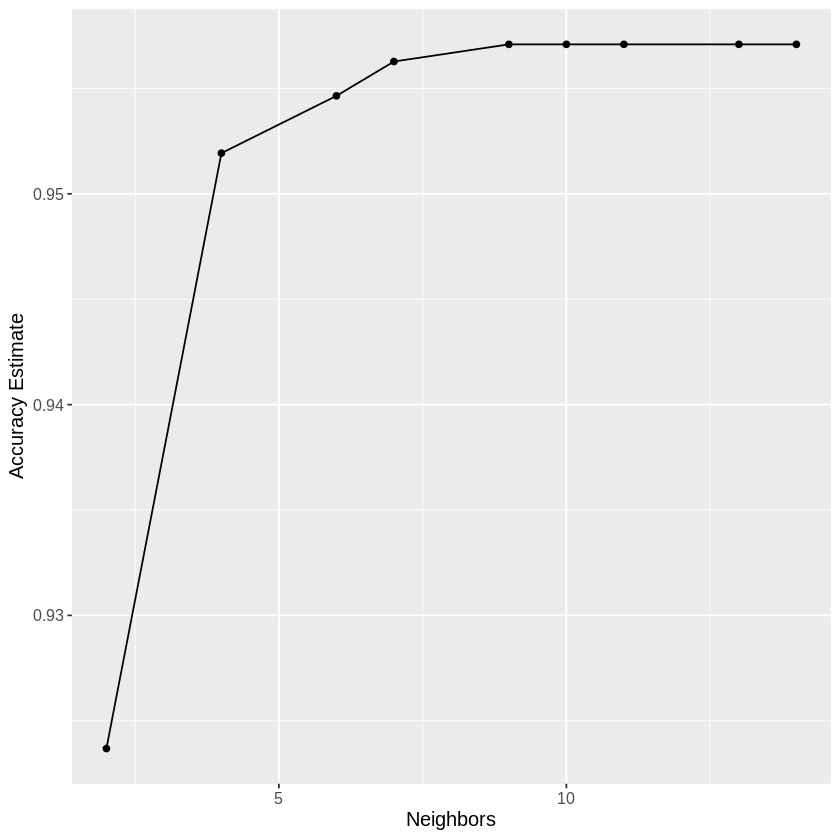

In [3]:
# scale and standardize predictors
# Due to imbalance in count, more non stroke than stroke cases, must account for this
#stroke_recipe <- recipe(stroke ~ bmi + avg_glucose_level, data = stroke_train) %>%
#    step_scale(all_predictors()) %>%
#    step_center(all_predictors()) %>%
#    step_upsample(stroke, over_ratio = 1, skip = FALSE) %>%
#    prep()

#CHOOSE BEST K

stroke_recipe <- recipe(stroke ~ ., data = stroke_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    themis::step_upsample(stroke, over_ratio = 1, skip = FALSE) %>%
    prep() %>%
    bake(stroke_train)
stroke_recipe

#upsampled_stroke <- bake(stroke_recipe, stroke_train)

upsampled_stroke <- stroke_recipe %>%
    group_by(stroke) %>%
    summarize(n = n())
upsampled_stroke

dummy_recipe <- recipe(stroke ~., data = stroke_recipe)

# 5-fold cross-valiation on training set
stroke_vfold <- vfold_cv(stroke_train, v = 5, strata = stroke)

# KNN classifier
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# kvals
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

# Create workflow analysis with recipe and model specs 
stroke_knn_results <- workflow() %>%
    add_recipe(dummy_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = stroke_vfold, grid = 10) %>%
    collect_metrics()
stroke_knn_results

# plot k vs accuracy 
stroke_knn_accuracies <- stroke_knn_results %>%
    filter(.metric == "accuracy")
stroke_knn_accuracies

# plot
cross_val_plot <- stroke_knn_accuracies %>%
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))
cross_val_plot


In [8]:
# BUILD MODEL WITH BEST K

# Using K = "X"
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) %>%
    set_engine("kknn") %>%
    set_mode("classification")
best_spec

best_fit <- workflow() %>%
    add_recipe(dummy_recipe) %>%
    add_model(best_spec) %>%
    fit(data = stroke_train) 
best_fit

                            

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 9
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~9, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.04345464
Best kernel: rectangular
Best k: 9

In [10]:
# Use Final Model to Predict on Test Dataset

stroke_predictions <- predict(best_fit, stroke_test) %>%
    bind_cols(stroke_test)
stroke_predictions

stroke_metrics <- stroke_predictions %>%
    metrics(truth = stroke, estimate = .pred_class)
stroke_metrics

stroke_conf_mat <- stroke_predictions %>%
    conf_mat(truth = stroke, estimate = .pred_class)
stroke_conf_mat

.pred_class,stroke,bmi,avg_glucose_level
<fct>,<fct>,<dbl>,<dbl>
0,1,27.4,70.09
0,1,28.2,214.09
0,1,22.4,193.94
⋮,⋮,⋮,⋮
0,0,16.8,62.13
0,0,40.8,91.68
0,0,26.2,85.28


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9584352
kap,binary,0.0000000


          Truth
Prediction    0    1
         0 1176   51
         1    0    0

### Confusion Matrix
Confusion matrix shows 1176 observations correctly predicted as cases of no strokes, and 51 cases correctly predicted as cases of strokes.


## Discussion

## Works Cited

Boehme, Amelia K., et al. “Stroke Risk Factors, Genetics, and Prevention.” Circulation Research, 3 Feb. 2017, https://www.ahajournals.org/doi/full/10.1161/CIRCRESAHA.116.308398. 

Hägg-Holmberg, Stefanie, et al. “The Role of Blood Pressure in Risk of Ischemic and Hemorrhagic Stroke in Type 1 Diabetes - Cardiovascular Diabetology.” BioMed Central, BioMed Central, 9 July 2019, https://cardiab.biomedcentral.com/articles/10.1186/s12933-019-0891-4. 

Dataset source: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset
Author credentials: fedesoriano